In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
print(now_str())
print(torch.__version__)

9.2
[05/28 18:15:11]
1.4.0


In [2]:
in_dir = './14g_data/output/200528'
img_names = ['03052', '03067', '04917', '06250', '06550']
cam_indices = list(range(16))

In [5]:
tex_counts = {}
tex_sums = {}
tex_average = {}
for img_name in img_names:
    tex_count = np.zeros((1024, 1024)).astype(np.uint8)
    tex_sum = np.zeros((1024, 1024)).astype(np.float32)
    for cam_idx in cam_indices:
        in_path = in_dir + '/{}/{}/texturemap.npy'.format(img_name, cam_idx)
        tex_np = np.load(in_path).squeeze()
#         channel_max = np.max(np.max(tex_np, axis=0), axis=0)
#         channel_min = np.min(np.min(tex_np, axis=0), axis=0)
#         tex_np = (tex_np - channel_min) / (channel_max-channel_min)
#         tex_np = np.clip(tex_np, a_max=1.0, a_min=np.min(tex_np))
        tex_count = tex_count + np.where(tex_np > 0.0, 1, 0)
        tex_sum = tex_sum + np.where(tex_np > 0.0, tex_np, 0)
    print(in_path,':', tex_np.shape)
    tex_counts[img_name] = tex_count.astype(np.uint8)
    tex_sums[img_name] = tex_sum.astype(np.float32)
    tex_avg = tex_sum / np.where(tex_count > 0, tex_count, 1)
#     channel_max = np.max(np.max(tex_avg, axis=0), axis=0)
#     channel_min = np.min(np.min(tex_avg, axis=0), axis=0)
#     tex_avg = (tex_avg - channel_min)/(channel_max - channel_min)
    tex_average[img_name] = tex_avg.astype(np.float32)
    print('  {} | {} | ({}, {})'.format(tex_avg.shape, tex_avg.dtype, np.min(tex_avg), np.max(tex_avg)))

./14g_data/output/200528/03052/15/texturemap.npy : (1024, 1024)
  (1024, 1024) | float64 | (0.0, 1.71455979347229)
./14g_data/output/200528/03067/15/texturemap.npy : (1024, 1024)
  (1024, 1024) | float64 | (0.0, 2.0511043071746826)
./14g_data/output/200528/04917/15/texturemap.npy : (1024, 1024)
  (1024, 1024) | float64 | (0.0, 2.1261775493621826)
./14g_data/output/200528/06250/15/texturemap.npy : (1024, 1024)
  (1024, 1024) | float64 | (0.0, 2.07662034034729)
./14g_data/output/200528/06550/15/texturemap.npy : (1024, 1024)
  (1024, 1024) | float64 | (0.0, 2.0053230921427407)


In [7]:
print(tex_average.keys())

dict_keys(['03052', '03067', '04917', '06250', '06550'])


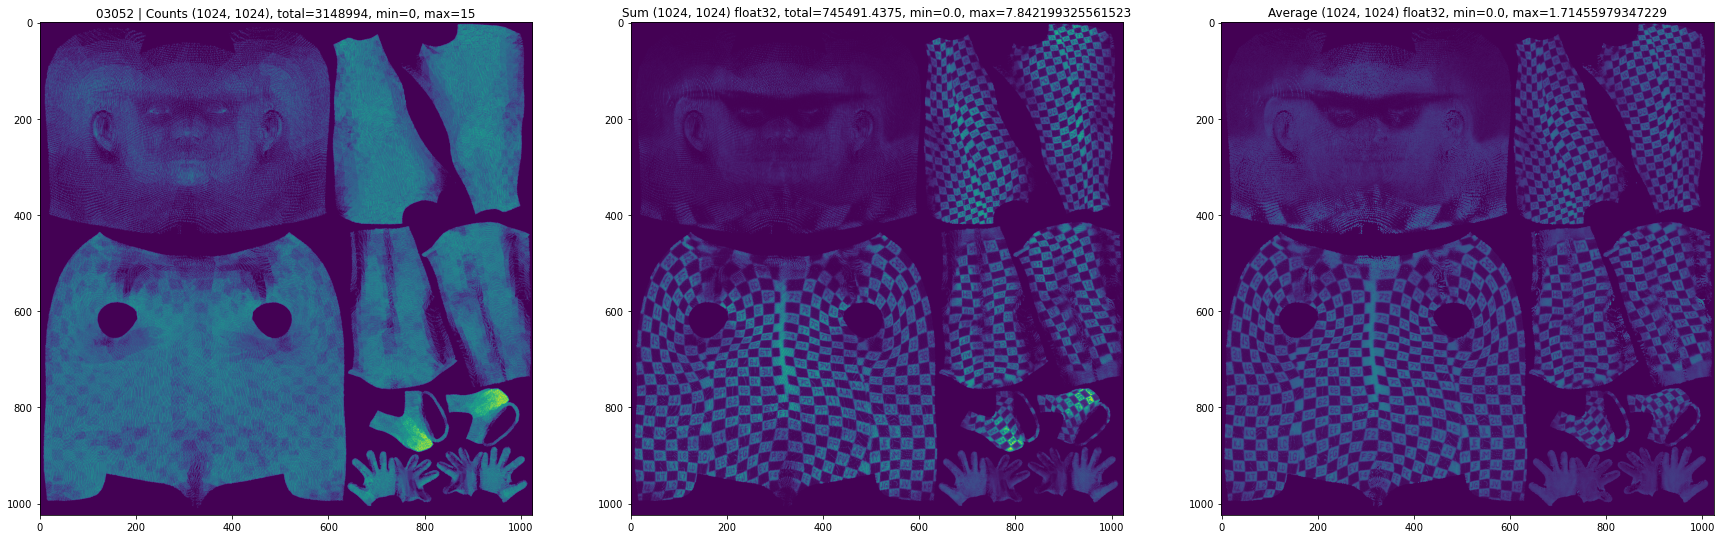

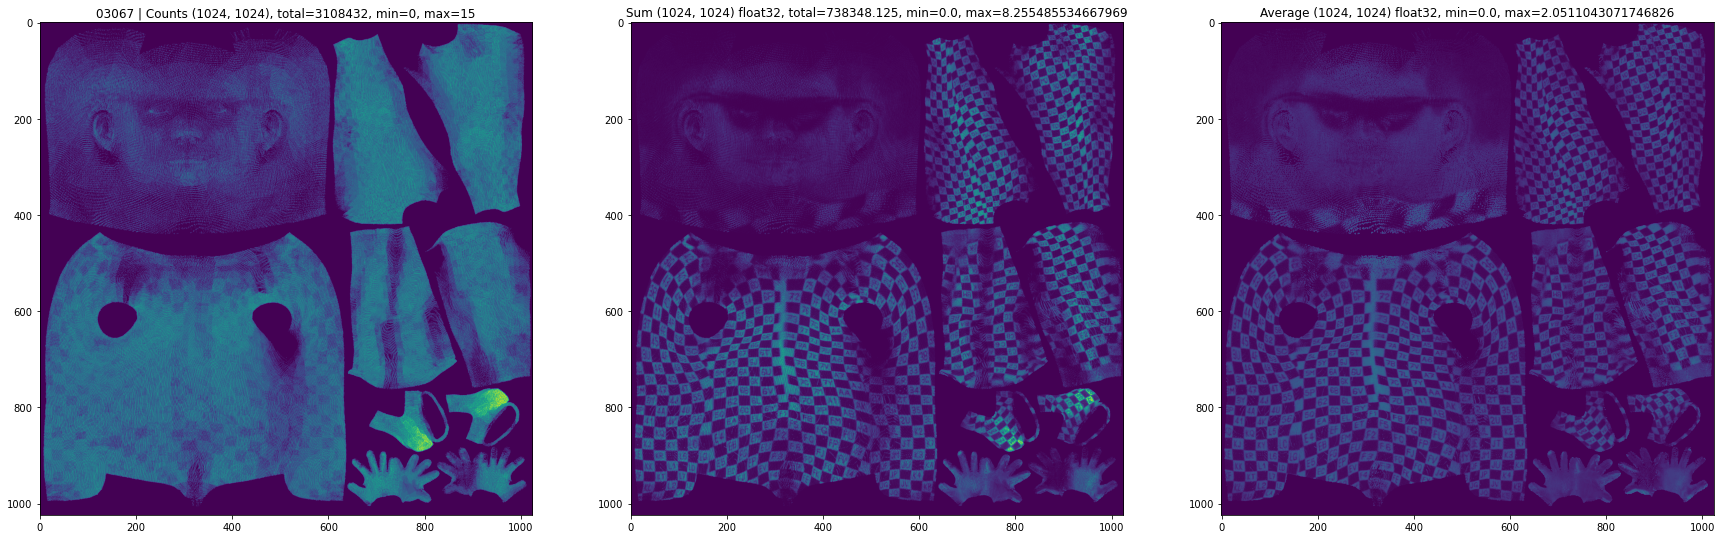

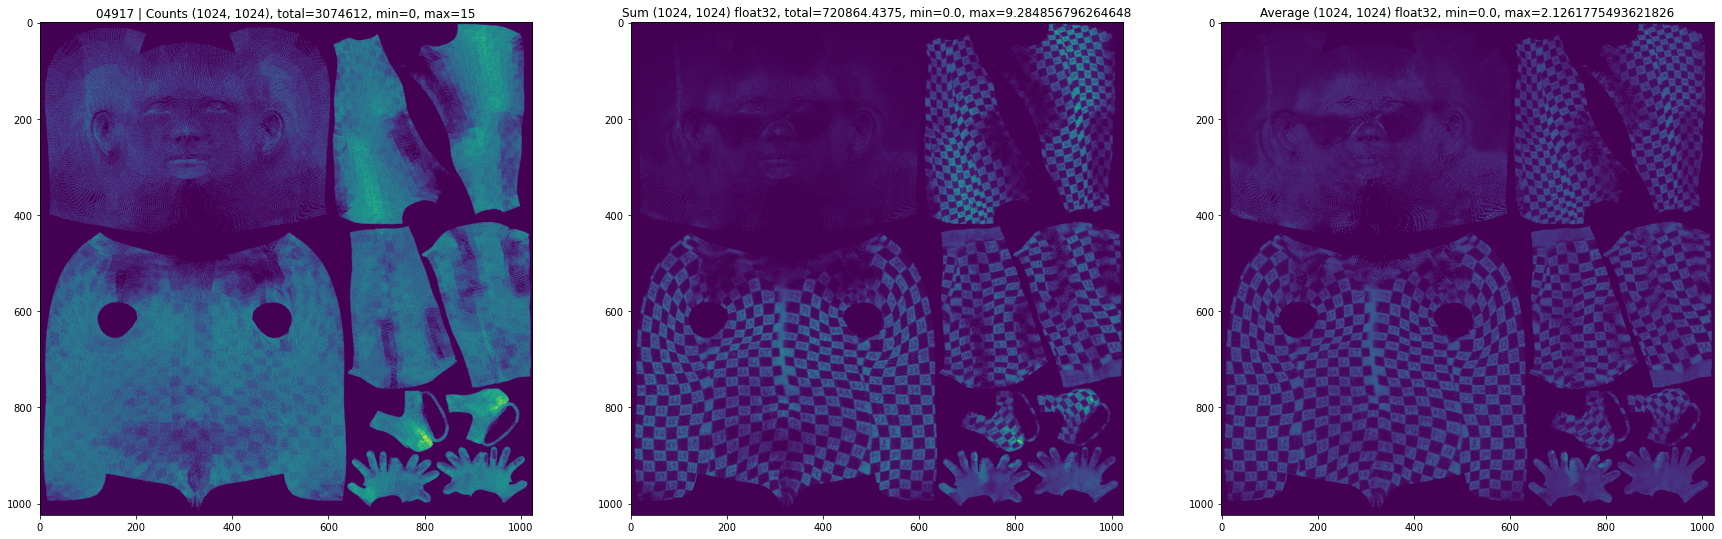

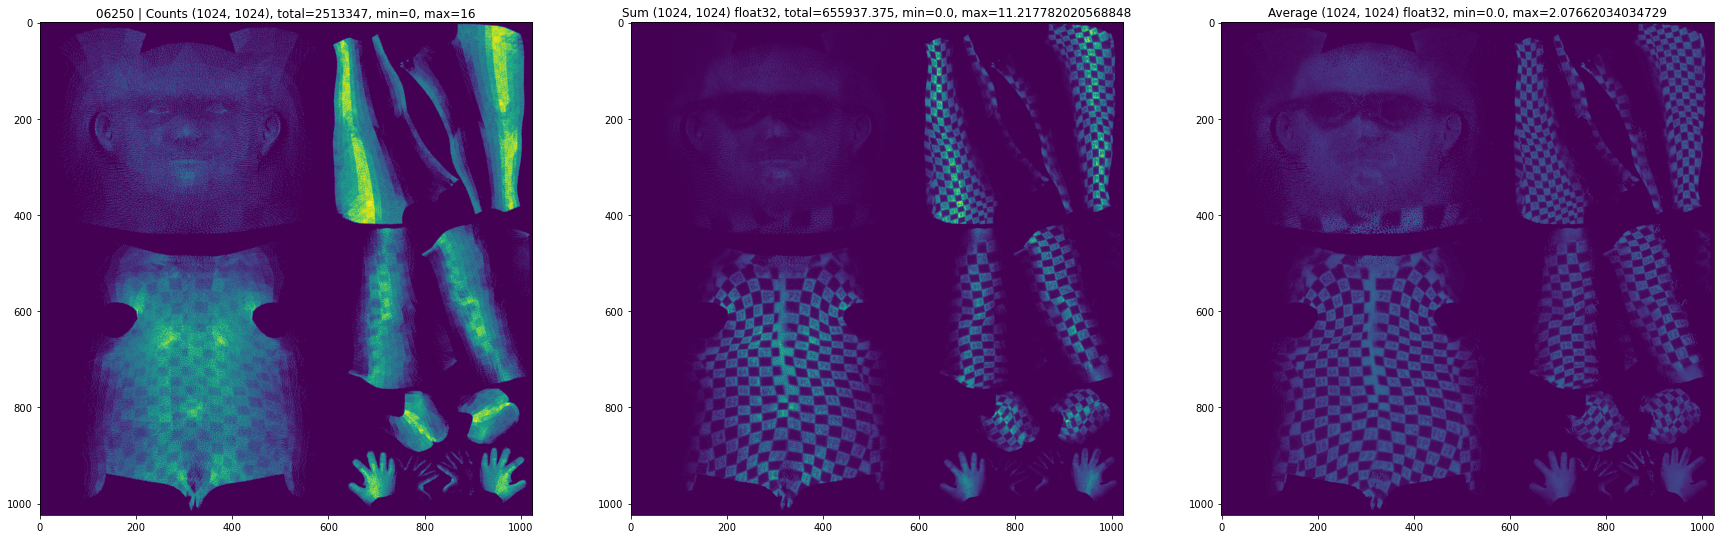

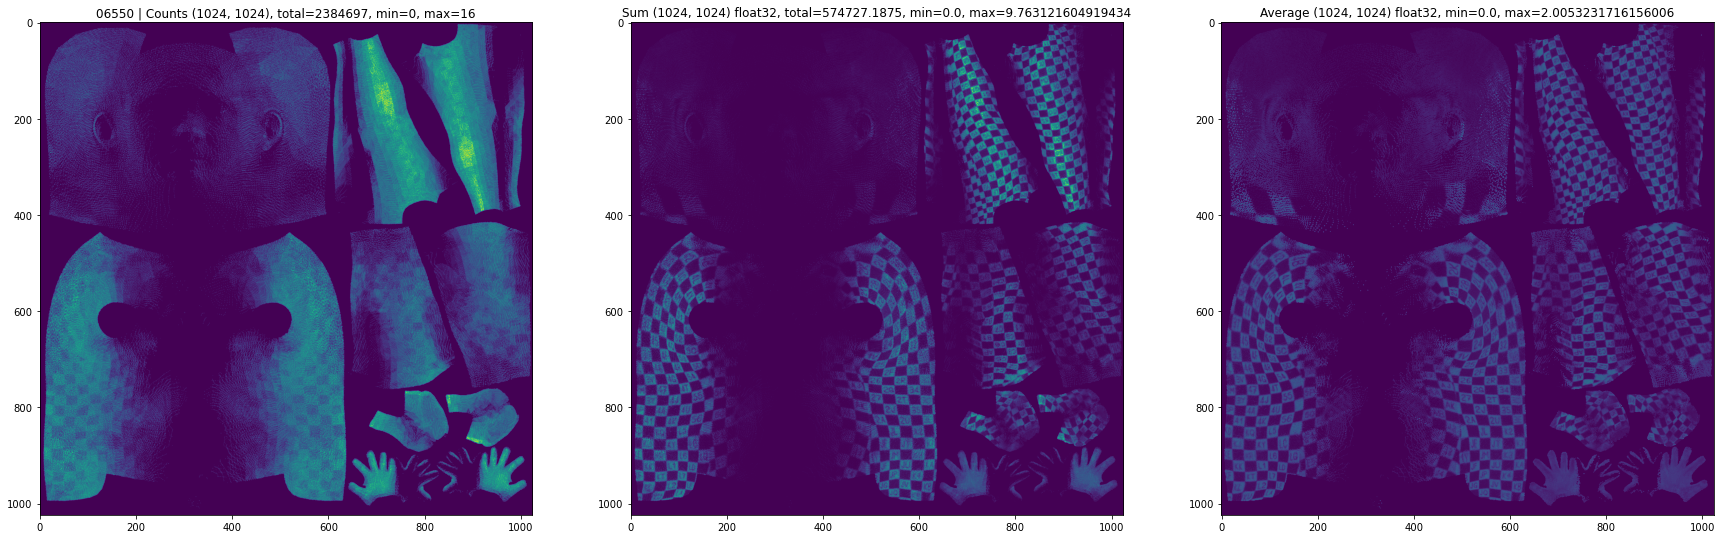

In [10]:
for img_name, tex_c in tex_counts.items():
    fig, ax = plt.subplots(1, 3, figsize=(30, 30))
    
    ax[0].set_title('{} | Counts {}, total={}, min={}, max={}'.format(img_name, tex_c.shape, np.sum(tex_c), np.min(tex_c), np.max(tex_c)))
    ax[0].imshow(tex_c)

    tex_s = tex_sums[img_name]
    ax[1].imshow(tex_s)
    ax[1].set_title('Sum {} {}, total={}, min={}, max={}'.format(tex_s.shape, tex_s.dtype, np.sum(tex_s), np.min(tex_s), np.max(tex_s)))

    tex_a = tex_average[img_name]
    ax[2].imshow(tex_a)
    ax[2].set_title('Average {} {}, min={}, max={}'.format(tex_a.shape, tex_a.dtype, np.min(tex_a), np.max(tex_a)))
    
    plt.show()

In [16]:
texturemap_count = np.zeros((1024, 1024)).astype(np.int32)
texturemap_avg = np.zeros((1024, 1024)).astype(np.float32)
for img_name, tex_c in tex_counts.items():
    tex_s = tex_sums[img_name]
    texturemap_avg += np.where(tex_s > 0.0, tex_s, 0)
    texturemap_count += tex_c
#texturemap_avg = np.where(texturemap_avg > 0.0, texturemap_avg, 1.0) / np.where(texturemap_count > 0, texturemap_count, 1)
texturemap_avg = texturemap_avg / np.where(texturemap_count > 0, texturemap_count, 1)
print('texturemap_avg:', texturemap_avg.shape, texturemap_avg.dtype, np.min(texturemap_avg), np.max(texturemap_avg))
# channel_max = np.max(np.max(texturemap_avg, axis=0), axis=0)
# channel_min = np.min(np.min(texturemap_avg, axis=0), axis=0)
# texturemap_avg = (texturemap_avg - channel_min)/(channel_max - channel_min)
# texturemap_avg = np.clip(texturemap_avg, a_min=0, a_max=1)
# texturemap_avg = texturemap_avg.astype(np.float32)
# texturemap_avg = np.clip(texturemap_avg, a_min=0, a_max=1)
print('texturemap_avg:', texturemap_avg.shape, texturemap_avg.dtype, np.min(texturemap_avg), np.max(texturemap_avg))

texturemap_avg: (1024, 1024) float64 0.0 1.8857735395431519
texturemap_avg: (1024, 1024) float64 0.0 1.8857735395431519


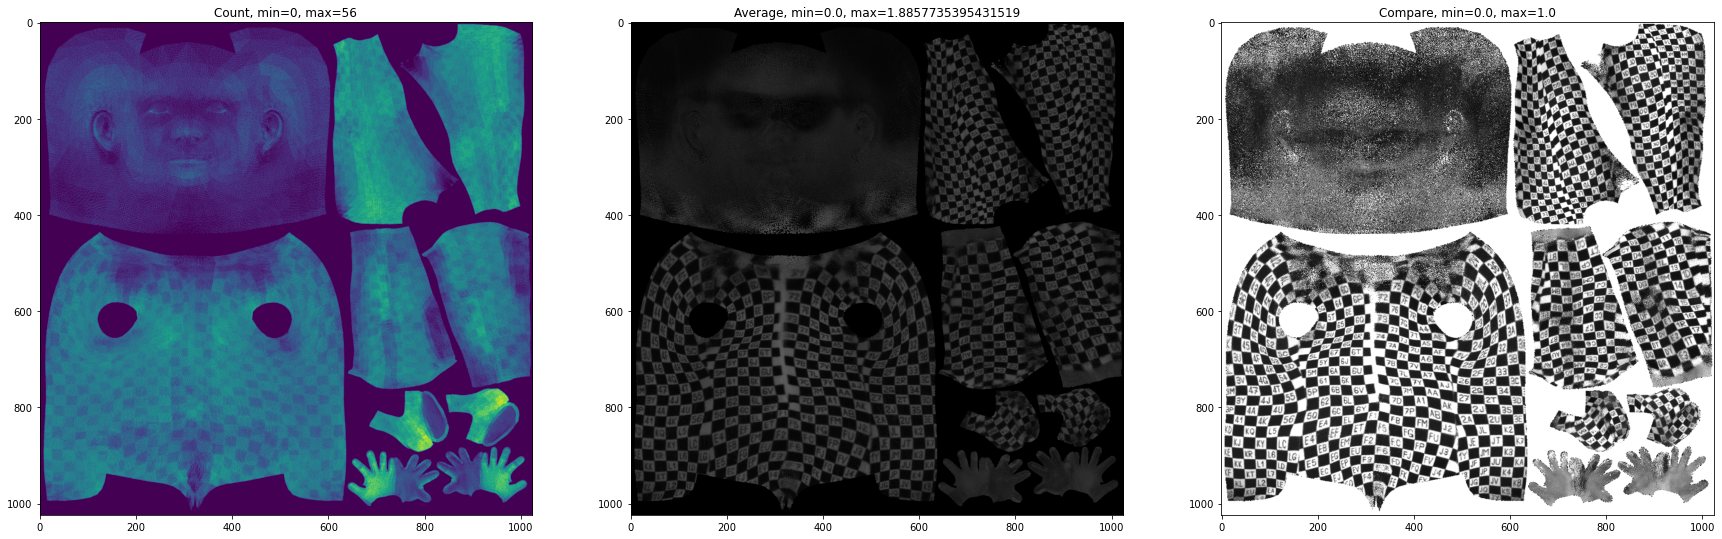

In [17]:
tex_comparison = np.load(r'D:\1_Projects\200325_PyTorch3d_Toy\9_data\output\200413_SingleVsMulti\multi_L1\texturemap.npy').squeeze()
tex_comparison = cv2.resize(tex_comparison, (1024, 1024))
tex_comparison = np.clip(tex_comparison, a_min=0, a_max=1)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(texturemap_count)
ax[0].set_title('Count, min={}, max={}'.format(np.min(texturemap_count), np.max(texturemap_count)))

ax[1].set_title('Average, min={}, max={}'.format(np.min(texturemap_avg), np.max(texturemap_avg)))
ax[1].imshow(texturemap_avg, cmap='gray')

ax[2].set_title('Compare, min={}, max={}'.format(np.min(tex_comparison), np.max(tex_comparison)))
ax[2].imshow(tex_comparison, cmap='gray', vmin=np.min(tex_comparison), vmax=np.max(tex_comparison))

plt.show()

# diff= tex_comparison - texturemap_avg
# plt.figure(figsize=(20, 20))
# plt.imshow(diff)
# plt.title('Difference, min={}, max={}'.format(np.min(diff), np.max(diff)))
# plt.show()

## binaryize

In [17]:
import cv2
def binarizer(image_in, p):
    image = (image_in*255.0).astype(np.uint8)
        
    binary_type = p['binary_type']
    if binary_type == 'thres':
        binary_thres = p['binary_thres']
        _, img1 = cv2.threshold(image, binary_thres, 255, cv2.THRESH_BINARY)
    elif binary_type == 'adaptive_mean':
        winsize = p['adaptive_mean_winsize']
        c = p['minus_c']
        img1 = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, winsize, c)
        img1 = 255 - cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, winsize, c)
    elif binary_type == 'adaptive_gaussian':
        winsize = p['adaptive_mean_winsize']
        c = p['minus_c']
        img1 = 255 - cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, winsize, c)
    elif binary_type == 'otsu':
        _, img1 = cv2.threshold(image, 0, 255, cv2. THRESH_BINARY + cv2.THRESH_OTSU)
    elif binary_type == 'blur_otsu':
        img1 = cv2.GaussianBlur(image, (11, 11), 0)
#         img1 = cv2.medianBlur(image, 7)
        _, img1 = cv2.threshold(img1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        assert(False)
    img1 = img1.astype(np.float32) / 255.0
    return img1

print('texturemap_avg:', texturemap_avg.shape, texturemap_avg.dtype, np.max(texturemap_avg))

params = {'binary_type': 'blur_otsu', 'adaptive_mean_winsize': 5, 'minus_c': 2, 'binary_thres': 255*0.5}
# texturemap_blurred = cv2.medianBlur((255*texturemap_avg).astype(np.uint8), 7)
texturemap_binary = binarizer(texturemap_avg, params)

fig, ax = plt.subplots(1, 2, figsize=(40, 20))
ax[0].imshow(texturemap_avg, cmap='gray')
ax[0].set_title('{} | {} | ({}, {})'.format(texturemap_avg.shape, texturemap_avg.dtype, np.min(texturemap_avg), np.max(texturemap_avg)))
ax[1].imshow(texturemap_binary, cmap='gray')
ax[1].set_title('{} | {} | ({}, {})'.format(texturemap_binary.shape, texturemap_binary.dtype, np.min(texturemap_binary), np.max(texturemap_binary)))
plt.show()

texturemap_avg: (1024, 1024, 3) float32 1.0


error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1529: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'cv::threshold'


In [18]:
save_path = r'.\14g_data\output\texturemap_averaged.png'
texturemap_out = (255.0*texturemap_avg).astype(np.uint8)
im = Image.fromarray(texturemap_out)
im.save(save_path, dpi=(600, 600))
print('saved:', save_path)

# save_path = r'D:\1_Projects\200325_PyTorch3d_Toy\14d_data\output\texturemap_binary_otsu.png'
# texturemap_out = (255.0*texturemap_binary).astype(np.uint8)
# im = Image.fromarray(texturemap_out)
# im.save(save_path, dpi=(600, 600))
# print('saved:', save_path)

saved: .\14g_data\output\texturemap_averaged.png


In [19]:
save_path = r'.\14g_data\output\texturemap_averaged.npy'
np.save(save_path, texturemap_avg)
print('saved:', save_path)

# save_path = r'D:\1_Projects\200325_PyTorch3d_Toy\14d_data\output\texturemap_binary_otsu.npy'
# np.save(save_path, texturemap_binary)
# print('saved:', save_path)

saved: .\14g_data\output\texturemap_averaged.npy
